<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_ARIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ライブラリインストール
install.packages( "tidyverse" )
install.packages( "fable" )
install.packages( "feasts" )
install.packages( "urca" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘progressr’, ‘anytime’, ‘numDeriv’, ‘fabletools’, ‘Rcpp’, ‘tsibble’, ‘distributional’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘slider’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は人口方程式の考え方に沿って時系列分析します。

>$t$年から$a$年後の人口$(P_{t+a})$は、基準人口$(P_t)$に$t$年から$t+a$年までの  
出生数$(B)$を加え死亡数$(D)$を減じ  
国籍取得数$(IN)$を加え国籍離脱数$(ON)$を減じたものです。  
$P_{t+a}={P_t}+{B_{t\to t+a}}－{D_{t\to t+a}}$
$+{IN_{t\to t+a}}-{ON_{t\to t+a}}$  

# 手順１　データの収集


*  [データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。
*  出生・死亡 [「人口動態調査」（厚生労働省）](https://www.mhlw.go.jp/toukei/list/81-1a.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [2]:
# 該当リポジトリを変数に格納
repo = 
  c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" )

# 人口推計に使うデータの格納場所を変数に格納
popURL = 
  c( "main/data/population_jp_year.csv" )

# ライブラリの読み込み
library( readr )
library( fable )

repo |>
  paste0( popURL ) |>                     # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  as_tsibble( index = Year ) ->           # ＴＳＩＢＢＬＥライブラリに変換
pop_tsibble

Loading required package: fabletools

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


# 手順２　データの可視化

まず、データをプロットしてみます。

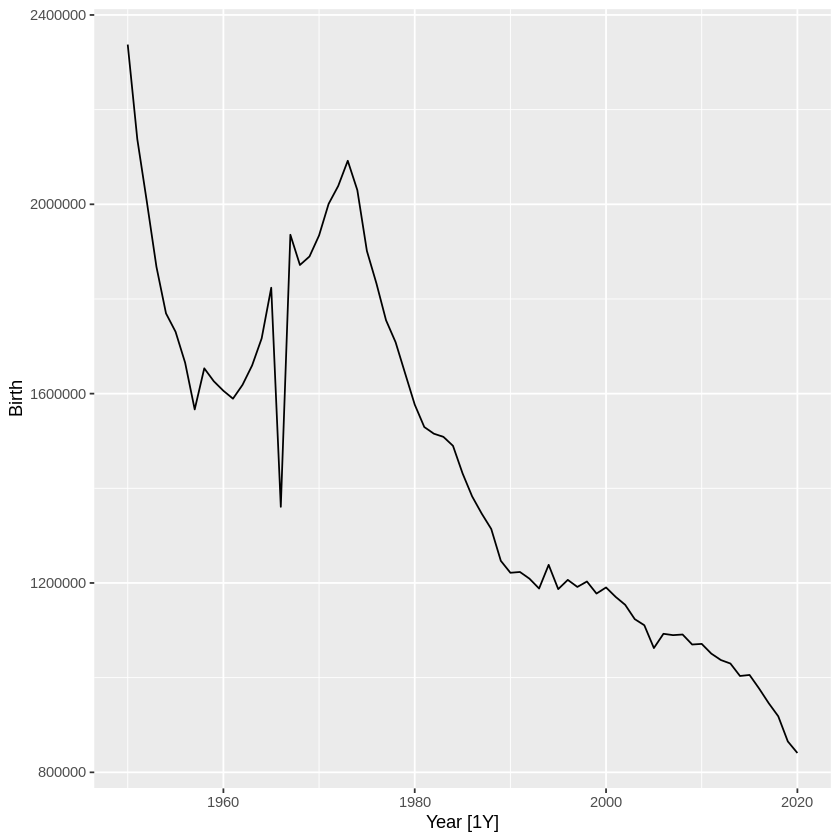

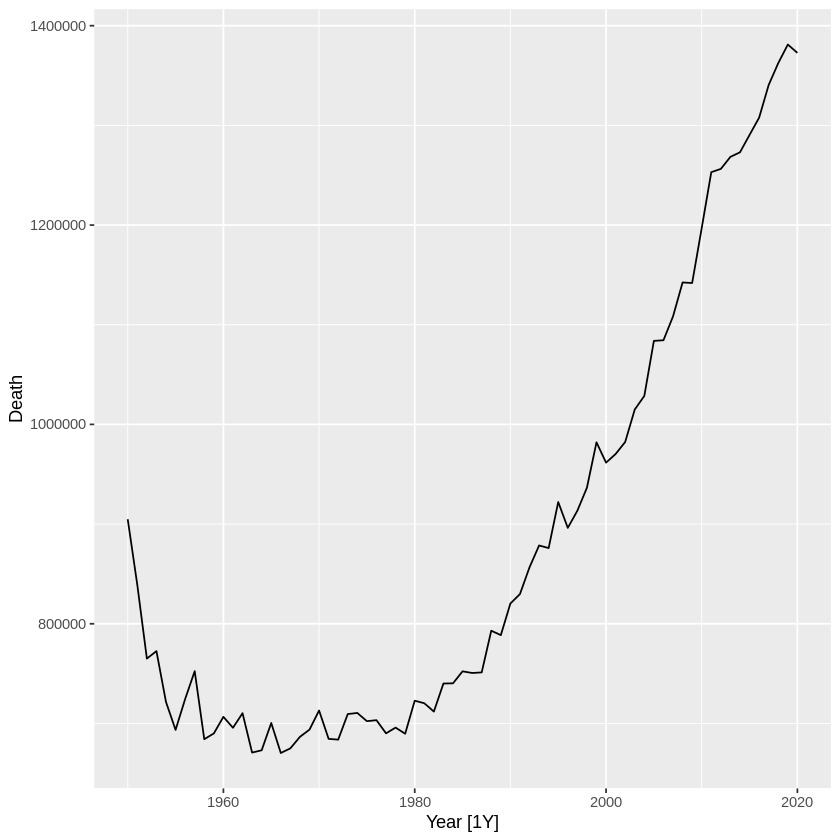

In [3]:
# ライブラリの読み込み
library( ggplot2 )

# 出生数、死亡数のグラフ
pop_tsibble |>
  autoplot( Birth )
pop_tsibble |>
  autoplot( Death )

次に、自己相関を確認してみます。

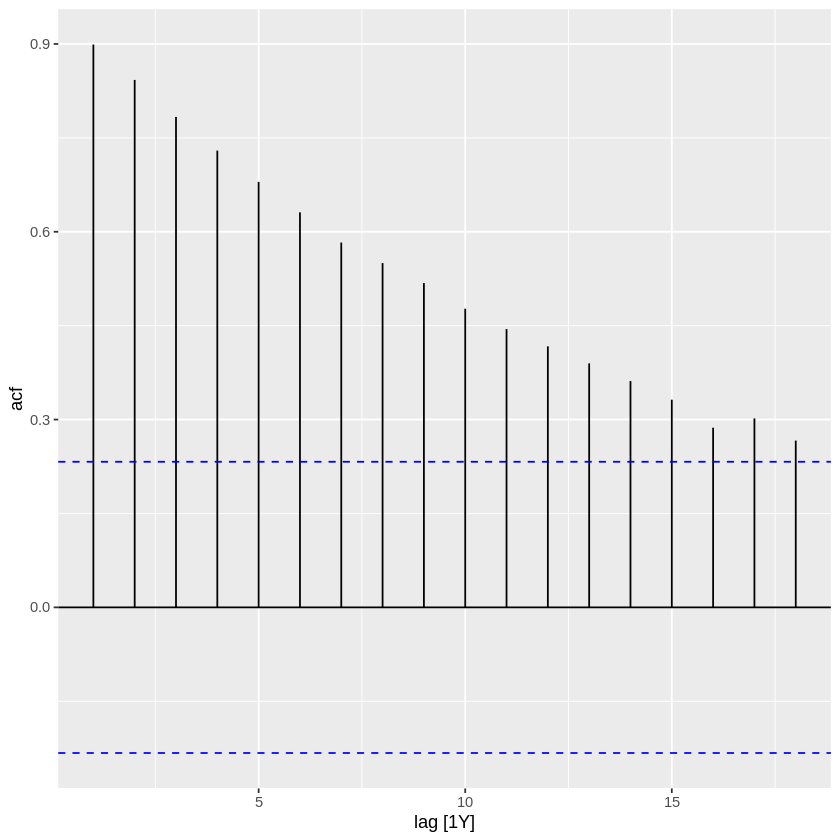

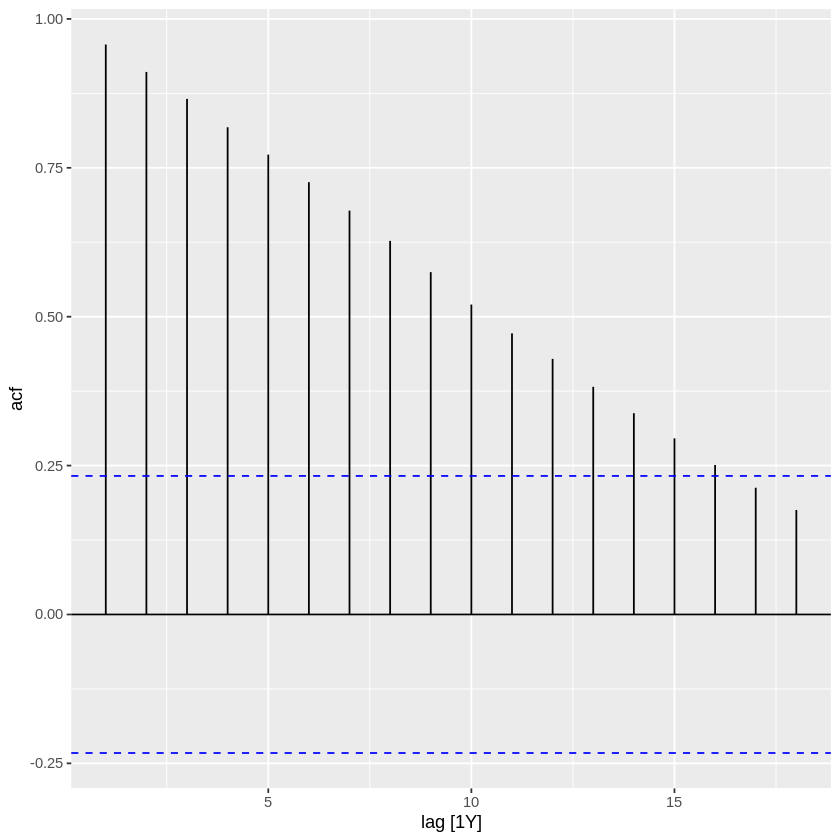

In [4]:
# ライブラリの読み込み
library( feasts )

# 自己相関のグラフ
pop_tsibble |>
  ACF( Birth ) |>
  autoplot()
pop_tsibble |>
  ACF( Death ) |>
  autoplot()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

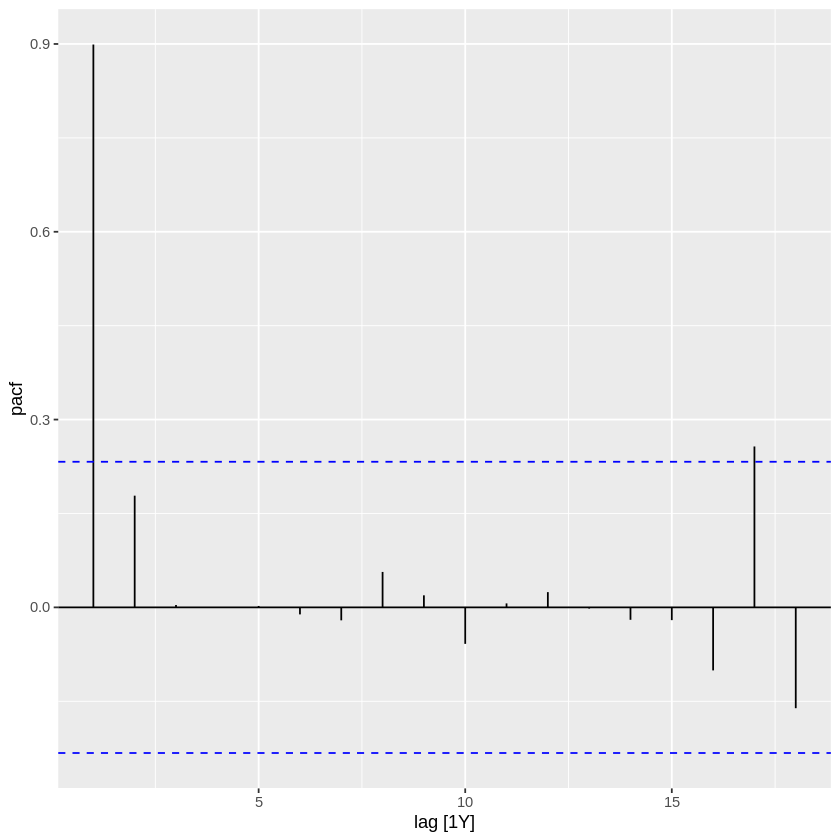

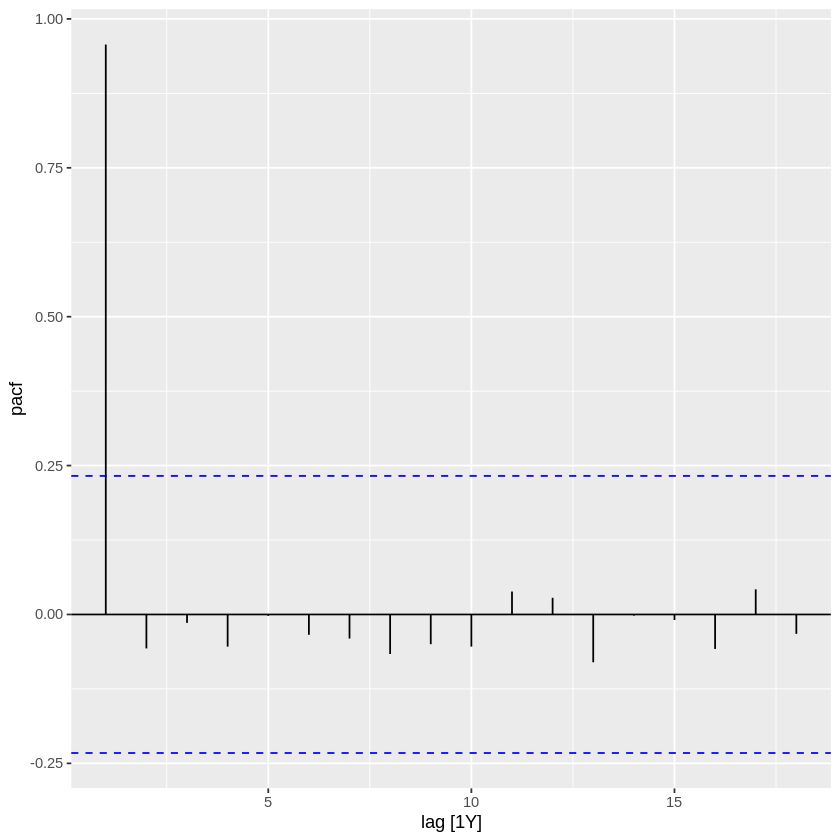

In [5]:
# 偏自己相関のグラフ
pop_tsibble |>
  PACF( Birth ) |>
  autoplot()
pop_tsibble |>
  PACF( Death ) |>
  autoplot()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [6]:
# 学習データと予測データ
prow_test2 = 6
prow_train2 = nrow( pop_tsibble ) - prow_test2

pop_tsibble |>
  tail( n = prow_test2 ) ->
pop_test2

pop_tsibble |>
  head( n = prow_train2 ) ->
pop_train2

# 手順４　ＡＲＩＭＡモデルによる予測

学習データを使ってＡＲＩＭＡモデルを推定していきます。  
まず、出生についてモデルを自動推定させ、ＡＩＣが＋２までのモデルを候補にします。

In [7]:
# ライブラリの読み込み
library( dplyr )

# ＡＩＣが自動推定＋２までのモデルを候補として列挙
capture.output({
  pop_train2 |>
    model(
      arima = ARIMA( Birth,
                     ic = "aic",
                     trace = TRUE,
                     stepwise = FALSE ))
}) |>
  read_table( col_names = c( "symbol", "AIC" ),
              col_types = "cn",
              comment = "<" ) |>
  na.omit() ->
trace_arimaB

max_AICB = min( trace_arimaB$AIC ) + 2
trace_arimaB |>
  filter( AIC < max_AICB ) 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“31 parsing failures.
row col expected actual         file
 14 AIC a number    Inf literal data
 15 AIC a number    Inf literal data
 16 AIC a number    Inf literal data
 17 AIC a number    Inf literal data
 18 AIC a number    Inf literal data
... ... ........ ...... ............
See problems(...) for more details.
”


symbol,AIC
<chr>,<dbl>
"ARIMA(1,1,0)(0,0,0)[1]+c",1661.006
"ARIMA(3,1,0)(0,0,0)[1]+c",1661.357
"ARIMA(4,1,0)(0,0,0)[1]+c",1660.440
"ARIMA(5,1,0)(0,0,0)[1]+c",1661.660
"ARIMA(2,1,1)(0,0,0)[1]+c",1661.718
"ARIMA(3,1,1)(0,0,0)[1]+c",1660.910
"ARIMA(0,1,2)(0,0,0)[1]+c",1659.753
"ARIMA(4,1,0)(0,0,0)[1]",1660.324
"ARIMA(5,1,0)(0,0,0)[1]",1661.303


列挙されたモデルで６年後までを予測し、  
２０２０年の実測した出生数に最も近いモデルを採用することにします。

In [8]:
pop_train2 |>
  model(
    arimaB012 = ARIMA( Birth ~ 0 + pdq( 0, 1, 2 )),    
    arimaB110 = ARIMA( Birth ~ 0 + pdq( 1, 1, 0 )),
    arimaB310 = ARIMA( Birth ~ 0 + pdq( 3, 1, 0 )),
    arimaB410 = ARIMA( Birth ~ 0 + pdq( 4, 1, 0 )),
    arimaB510 = ARIMA( Birth ~ 0 + pdq( 5, 1, 0 )),
    arimaB211 = ARIMA( Birth ~ 0 + pdq( 2, 1, 1 )), 
    arimaB311 = ARIMA( Birth ~ 0 + pdq( 3, 1, 1 )),
    arimaB411 = ARIMA( Birth ~ 0 + pdq( 4, 1, 1 ))) ->
pop_arimaB

# ＡＲＩＭＡによる予測
pop_arimaB |>
  forecast( h = "6 years") ->
pop_arimaB_f
pop_arimaB_f |>
  filter( Year == 2020 ) 
pop_test2 |>
  select( Year, Birth ) |>
  tail( 1 )

.model,Year,Birth,.mean
<chr>,<dbl>,<dist>,<dbl>
arimaB012,2020,"N(1e+06, 4.9e+10)",1002913.3
arimaB110,2020,"N(1e+06, 4.1e+10)",1009928.9
arimaB310,2020,"N(988679, 6.8e+10)",988679.1
arimaB410,2020,"N(964741, 7e+10)",964741.4
arimaB510,2020,"N(956386, 6.8e+10)",956386.0
arimaB211,2020,"N(970142, 6.9e+10)",970141.6
arimaB311,2020,"N(961711, 6.8e+10)",961710.9
arimaB411,2020,"N(956630, 6.8e+10)",956629.7


Year,Birth
<dbl>,<dbl>
2020,840835


出生では、ＡＲＩＭＡ（５，１，０）を採用する事にします。  
同様に、死亡についても同じ作業を行います。

In [10]:
# ＡＩＣが自動推定＋２までのモデルを候補として列挙
capture.output({
  pop_train2 |>
    model(
      arima = ARIMA( Death,
                     ic = "aic",
                     trace = TRUE,
                     stepwise = FALSE ))
}) |>
  read_table( col_names = c( "symbol", "AIC" ),
              col_types = "cn",
              comment = "<" ) |>
  na.omit() ->
trace_arimaD

max_AICD = min( trace_arimaD$AIC ) + 2
trace_arimaD |>
  filter( AIC < max_AICD ) 

Warning message:
“6 parsing failures.
row col  expected    actual         file
 23 AIC a number  Inf       literal data
 27 AIC a number  A         literal data
 27 NA  2 columns 6 columns literal data
 28 NA  2 columns 1 columns literal data
 29 NA  2 columns 1 columns literal data
... ... ......... ......... ............
See problems(...) for more details.
”


symbol,AIC
<chr>,<dbl>
"ARIMA(2,2,1)(0,0,0)[1]",1461.351
"ARIMA(3,2,1)(0,0,0)[1]",1463.321
"ARIMA(0,2,2)(0,0,0)[1]",1461.675
"ARIMA(1,2,2)(0,0,0)[1]",1462.465
"ARIMA(2,2,2)(0,0,0)[1]",1463.139
"ARIMA(0,2,3)(0,0,0)[1]",1461.454
"ARIMA(1,2,3)(0,0,0)[1]",1462.725
"ARIMA(0,2,4)(0,0,0)[1]",1462.615


In [13]:
pop_train2 |>
  model(
    arimaD221 = ARIMA( Death ~ 0 + pdq( 2, 2, 1 )),    
    arimaD321 = ARIMA( Death ~ 0 + pdq( 3, 2, 1 )),
    arimaD022 = ARIMA( Death ~ 0 + pdq( 0, 2, 2 )),
    arimaD122 = ARIMA( Death ~ 0 + pdq( 1, 2, 2 )),
    arimaD222 = ARIMA( Death ~ 0 + pdq( 2, 2, 2 )),
    arimaD023 = ARIMA( Death ~ 0 + pdq( 0, 2, 3 )),
    arimaD123 = ARIMA( Death ~ 0 + pdq( 1, 2, 3 )),
    arimaD024 = ARIMA( Death ~ 0 + pdq( 0, 2, 4 ))) ->
pop_arimaD

# ＡＲＩＭＡによる予測
pop_arimaD |>
  forecast( h = "6 years") ->
pop_arimaD_f
pop_arimaD_f |>
  filter( Year == 2020 ) 
pop_test2 |>
  select( Year, Death ) |>
  tail( 1 )

.model,Year,Death,.mean
<chr>,<dbl>,<dist>,<dbl>
arimaD221,2020,"N(1401214, 5.3e+09)",1401214
arimaD321,2020,"N(1402237, 5.4e+09)",1402237
arimaD022,2020,"N(1406281, 5.3e+09)",1406281
arimaD122,2020,"N(1415677, 5.3e+09)",1415677
arimaD222,2020,"N(1407965, 5.6e+09)",1407965
arimaD023,2020,"N(1414514, 5.4e+09)",1414514
arimaD123,2020,"N(1409795, 5.5e+09)",1409795
arimaD024,2020,"N(1406107, 5.6e+09)",1406107


Year,Death
<dbl>,<dbl>
2020,1372755


死亡では、ＡＲＩＭＡ（２，２，１）を採用する事にします。  

# 手順５　出生数、死亡数から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [14]:
# 出生数、死亡数の合算
pop_test2 |>
  rename( "forecast_BD" = Total ) ->
pop_arima_f2

pop_arimaB_f |>
  as.data.frame() |>
  filter( .model == "arimaB510" ) |>
  select( .mean ) ->
pop_arima_f2[, 3 ]

pop_arimaD_f |>
  as.data.frame() |>
  filter( .model == "arimaD221" ) |>
  select( .mean ) ->
pop_arima_f2[, 4 ]

pop_arima_f2 |>
  mutate( forecast_BD = lag( forecast_BD + Birth - Death )) ->
pop_arima_f2

# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast_BD,DMBM,DMBH,DLBM,DLBH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,126933000,126793971,126838000,126864000,126912000,126938000
2017,126706000,126597389,126532000,126605000,126704000,126777000
2018,126443000,126344847,126177000,126315000,126441000,126580000
2019,126167000,126052080,125773000,125998000,126125000,126351000
2020,126146000,125747971,125325000,125658000,125761000,126094000


Plot variable not specified, automatically selected `.vars = Birth`


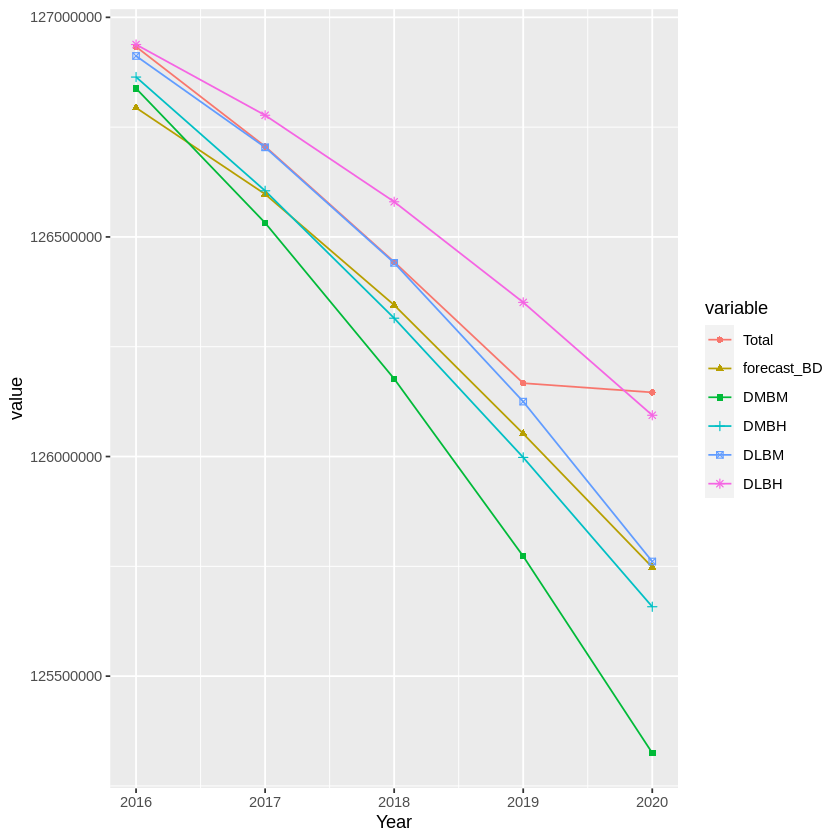

Plot variable not specified, automatically selected `.vars = Death`


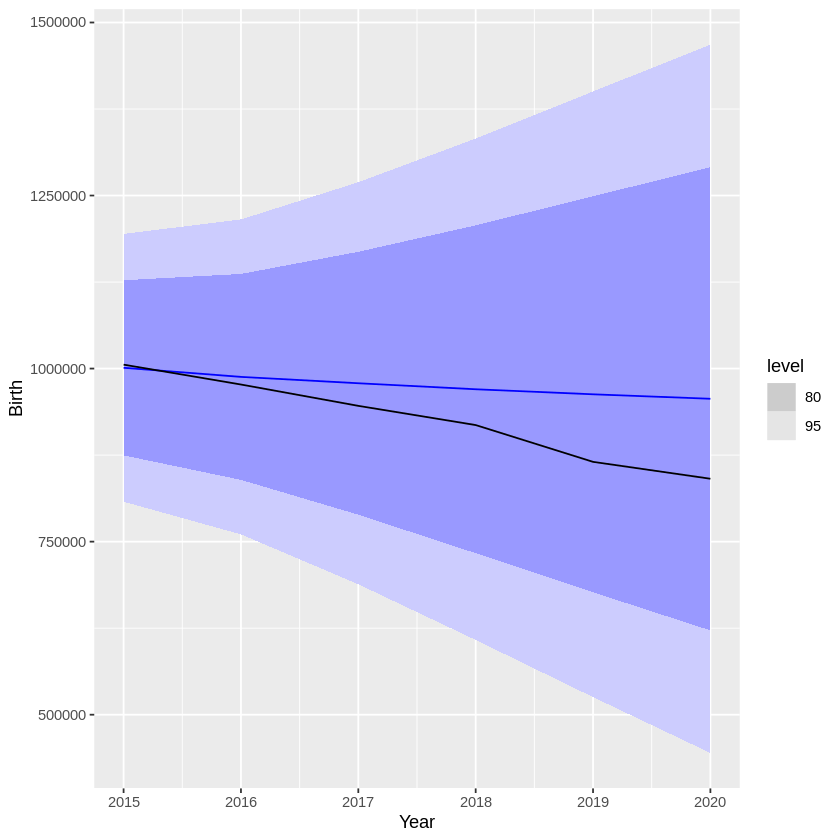

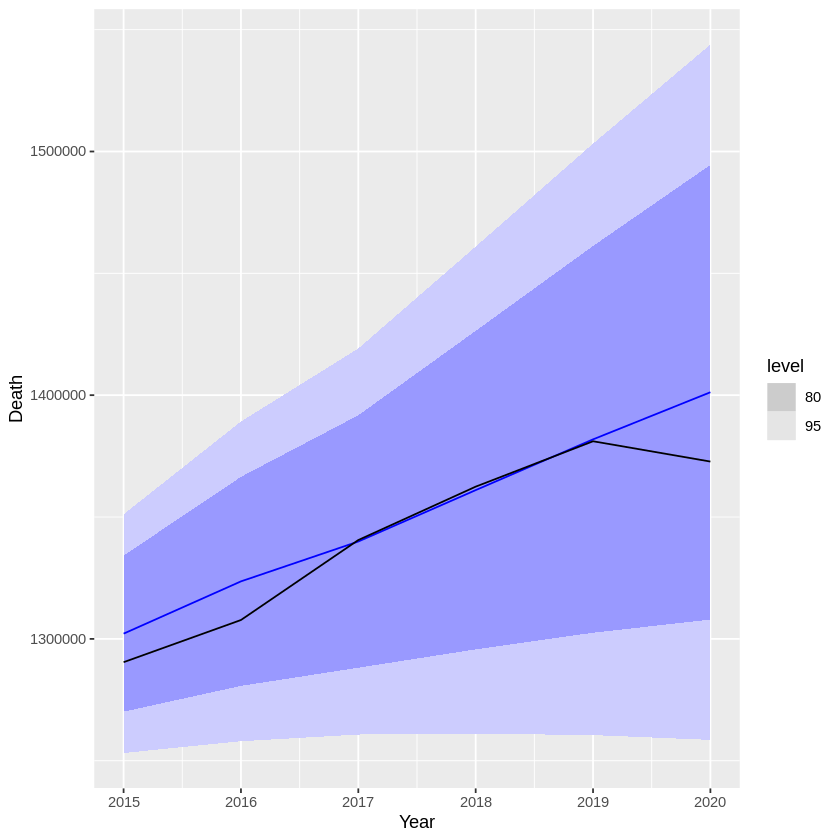

In [15]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
ipssURL = 
  c( "main/data/forecast_ipss.csv" )

repo |>
  paste0( ipssURL ) |>                    # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  as_tsibble( index = Year ) ->           # ＴＳＩＢＢＬＥライブラリに変換
  ipss_test

pop_arima_f2[ 2:6, 1:2 ] |>
  inner_join( pop_test2, by = "Year") |>
  inner_join( ipss_test, by = "Year") |>
  select( Year,
          Total,
          forecast_BD,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) ->
join_test2
join_test2

# ライブラリの読み込み
library( reshape2 )

# 描画
join_test2 |> 
  melt(id = "Year",
       measure = c( "Total",
                    "forecast_BD",
                    "DMBM",
                    "DMBH",
                    "DLBM",
                    "DLBH")) |>
  ggplot( aes(x = Year,
              y = value,
              shape = variable,
              colour = variable,
              group = variable )) +
  geom_line() +
  geom_point()

pop_test2 |>
  select( Year, Birth ) ->
pop_testB

pop_arimaB_f |>
  filter( .model == "arimaB510" ) |>
  autoplot() +
  autolayer( pop_testB )

pop_test2 |>
  select( Year, Death ) ->
pop_testD

pop_arimaD_f |>
  filter( .model == "arimaD221" ) |>
  autoplot() +
  autolayer( pop_testD )

今度は少し低めに出てしまいました。  
どうやら、出生数を低めに、死亡数は高めに見積もっているようです。

# 次のステップ


*   同じ事をPythonでやってみる。　->　 [ Python_ARIMA_2 ](https://colab.research.google.com/drive/1Hqauyd81PvWexKfJvrkYFm8YTfW4MplS?usp=sharing)
*    同じ事をＶＡＲモデルでやってみる。　->　[ R_VAR_2 ](https://colab.research.google.com/drive/13H3iLbnLvcK_POSiQ7IM5XWzXfBGNC2V?usp=sharing) 
*   死亡率を使って推計する　->　[ R_ARIMA_3 ](https://colab.research.google.com/drive/1MZ2XYpcnUZ8Dg7uYU-BEqRQOPy0y7u8r?usp=sharing)
